In [1]:
import pandas as pd
import numpy as np
import json

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
df_labels= 'data.info.txt'
df_labels = pd.read_csv(df_labels, delimiter=',')

In [3]:
df_raw = 'dataset0.json'

# Open the file and read line by line (each line = one read)
with open(df_raw, 'r') as file:
    data_list = []
    for line in file:
        try:
            data = json.loads(line)  # Parse each line as a separate JSON object
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line: {line}")
            print(f"Error message: {e}")

# Optionally pretty-print the first JSON object for readability
if data_list:
    formatted_data = json.dumps(data_list[0], indent=4)
    print(formatted_data)

{
    "ENST00000000233": {
        "244": {
            "AAGACCA": [
                [
                    0.00299,
                    2.06,
                    125.0,
                    0.0177,
                    10.4,
                    122.0,
                    0.0093,
                    10.9,
                    84.1
                ],
                [
                    0.00631,
                    2.53,
                    125.0,
                    0.00844,
                    4.67,
                    126.0,
                    0.0103,
                    6.3,
                    80.9
                ],
                [
                    0.00465,
                    3.92,
                    109.0,
                    0.0136,
                    12.0,
                    124.0,
                    0.00498,
                    2.13,
                    79.6
                ],
                [
                    0.00398,
                    2.06,
                    

In [5]:
print(len(df_labels))
print(df_labels[0:5])

121838
           gene_id    transcript_id  transcript_position  label
0  ENSG00000004059  ENST00000000233                  244      0
1  ENSG00000004059  ENST00000000233                  261      0
2  ENSG00000004059  ENST00000000233                  316      0
3  ENSG00000004059  ENST00000000233                  332      0
4  ENSG00000004059  ENST00000000233                  368      0


In [6]:
print(len(data_list))
for dat in data_list[0:5]:
    print(dat)
    for _,pos in dat.items():
        for _,seq in pos.items():
            for _, measurements in seq.items():
                continue

121838
{'ENST00000000233': {'244': {'AAGACCA': [[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0.0093, 10.9, 84.1], [0.00631, 2.53, 125.0, 0.00844, 4.67, 126.0, 0.0103, 6.3, 80.9], [0.00465, 3.92, 109.0, 0.0136, 12.0, 124.0, 0.00498, 2.13, 79.6], [0.00398, 2.06, 125.0, 0.0083, 5.01, 130.0, 0.00498, 3.78, 80.4], [0.00664, 2.92, 120.0, 0.00266, 3.94, 129.0, 0.013, 7.15, 82.2], [0.0103, 3.83, 123.0, 0.00598, 6.45, 126.0, 0.0153, 1.09, 74.8], [0.00398, 3.75, 126.0, 0.00332, 4.3, 129.0, 0.00299, 1.93, 81.9], [0.00498, 3.93, 127.0, 0.00398, 2.51, 131.0, 0.0111, 3.47, 79.4], [0.0139, 4.69, 106.0, 0.0136, 6.21, 124.0, 0.00531, 10.6, 85.5], [0.00631, 3.5, 126.0, 0.0222, 5.38, 128.0, 0.00332, 1.72, 79.3], [0.0061, 3.99, 121.0, 0.0121, 7.27, 122.0, 0.00232, 1.27, 78.9], [0.00299, 1.99, 128.0, 0.00427, 4.85, 124.0, 0.00332, 3.18, 80.5], [0.0186, 3.62, 124.0, 0.00428, 2.25, 129.0, 0.00554, 2.78, 80.1], [0.0093, 3.12, 125.0, 0.00398, 8.84, 129.0, 0.00361, 1.86, 82.0], [0.00365, 2.92, 126.0, 0.00698, 3.

In [7]:
unique_gene_ids = df_labels['gene_id'].nunique()
gene_id_counts = df_labels['gene_id'].value_counts()

unique_transcript_ids = df_labels['transcript_id'].nunique()
transcript_id_counts = df_labels['transcript_id'].value_counts()

label_counts = df_labels['label'].value_counts()

print(unique_gene_ids)
print(unique_transcript_ids)
print(label_counts)

3852
5333
label
0    116363
1      5475
Name: count, dtype: int64


In [107]:
# aggregating data_list
def create_aggregated_dataframe(data_list):
    rows = []
    for data in data_list:
        for transcript_id, positions in data.items():
            for position, sequence_data in positions.items():
                for sequence, measurements in sequence_data.items():
                    # Convert to numpy array for easier aggregation
                    scores_array = np.array(measurements)
                    
                    # Calculate the mean, sum, max, and min along the rows
                    mean_scores = np.mean(scores_array, axis=0)
                    var_scores = np.var(scores_array, axis=0)
                    max_scores = np.max(scores_array, axis=0)
                    min_scores = np.min(scores_array, axis=0)

                    transcript_position = {
                        'transcript_id': transcript_id,
                        'transcript_position': position,
                    }
                    
                    for idx in range(scores_array.shape[1]): 

                        transcript_position.update({
                            f'mean {idx}': mean_scores[idx],
                            f'var {idx}': var_scores[idx],
                            f'max {idx}': max_scores[idx],
                            f'min {idx}': min_scores[idx]
                        })
                    rows.append(transcript_position)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    return df

# Create the DataFrame
aggregated_df = create_aggregated_dataframe(data_list)

In [9]:
print(aggregated_df[0:5])

     transcript_id transcript_position    mean 0    sum 0   max 0    min 0  \
0  ENST00000000233                 244  0.008264  1.52891  0.0339  0.00199   
1  ENST00000000233                 261  0.006609  1.13679  0.0222  0.00199   
2  ENST00000000233                 316  0.007570  1.40045  0.0299  0.00232   
3  ENST00000000233                 332  0.010620  2.12405  0.0370  0.00232   
4  ENST00000000233                 368  0.010701  2.11870  0.0478  0.00199   

     mean 1     sum 1  max 1  min 1  ...   max 6    min 6    mean 7    sum 7  \
0  4.223784   781.400   13.4  1.770  ...  0.0329  0.00232  4.386989  811.593   
1  3.216424   553.225   17.0  0.919  ...  0.0262  0.00232  3.016599  518.855   
2  2.940541   544.000   11.6  1.280  ...  0.0266  0.00199  2.087146  386.122   
3  6.476350  1295.270   14.2  1.220  ...  0.0214  0.00199  2.236520  447.304   
4  6.415051  1270.180   39.0  1.150  ...  0.0485  0.00266  4.260253  843.530   

   max 7  min 7     mean 8    sum 8  max 8  min 8 

In [108]:
df_labels['transcript_position'] = df_labels['transcript_position'].astype(int)
aggregated_df['transcript_position'] = aggregated_df['transcript_position'].astype(int)

In [109]:
df_full = pd.merge(aggregated_df, df_labels[['transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')

In [98]:
print(df_full.columns)

Index(['transcript_id', 'transcript_position', 'mean 0', 'sum 0', 'max 0',
       'min 0', 'mean 1', 'sum 1', 'max 1', 'min 1', 'mean 2', 'sum 2',
       'max 2', 'min 2', 'mean 3', 'sum 3', 'max 3', 'min 3', 'mean 4',
       'sum 4', 'max 4', 'min 4', 'mean 5', 'sum 5', 'max 5', 'min 5',
       'mean 6', 'sum 6', 'max 6', 'min 6', 'mean 7', 'sum 7', 'max 7',
       'min 7', 'mean 8', 'sum 8', 'max 8', 'min 8', 'label'],
      dtype='object')


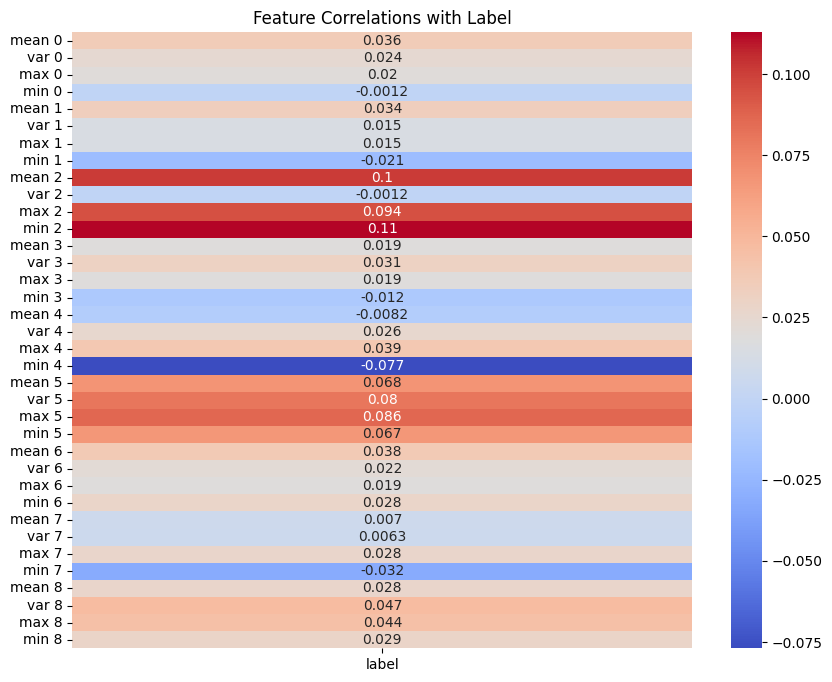

NameError: name 'df_features_ratioed' is not defined

In [111]:
### Start of training models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# FOR REFERENCE
# df_features_ratioed = raw data set pre train-test split and pre SMOTE and pre dropping of cols

df = df_full.drop(['transcript_id', 'transcript_position'], axis=1)

correlation_matrix = df.corr()
label_correlation = correlation_matrix['label'].drop('label')
plt.figure(figsize=(10, 8))
sns.heatmap(label_correlation.to_frame(), annot=True, cmap='coolwarm', cbar=True)

# Show the plot
plt.title('Feature Correlations with Label')
plt.show()

X = df_features_ratioed.drop(['transcript_id', 'position', 'rna_sequence', 'label', 'transcript_position', 'gene_id'], axis=1)
y = df_features_ratioed['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
df_full = pd.merge(aggregated_df, df_labels[['transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')

df_full_dat = df_full.copy()

df_full = df_full.groupby('transcript_id').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42))

# Reset the index to avoid hierarchical indexing after using apply
df_full = df_full.reset_index(drop=True)
print(df_full)


         transcript_id  transcript_position    mean 0     var 0   max 0  \
0      ENST00000000233                  244  0.008264  0.000029  0.0339   
1      ENST00000000233                  261  0.006609  0.000013  0.0222   
2      ENST00000000233                  471  0.006060  0.000014  0.0285   
3      ENST00000000233                  404  0.009011  0.000018  0.0277   
4      ENST00000000233                  332  0.010620  0.000037  0.0370   
...                ...                  ...       ...       ...     ...   
47713  ENST00000641834                  610  0.008452  0.000029  0.0313   
47714  ENST00000641834                 1093  0.008520  0.000023  0.0219   
47715  ENST00000641834                  474  0.006436  0.000012  0.0190   
47716  ENST00000641834                 1531  0.008161  0.000030  0.0315   
47717  ENST00000641834                 1348  0.009594  0.000038  0.0432   

         min 0    mean 1     var 1  max 1  min 1  ...    min 6    mean 7  \
0      0.00199  4.22378

C:\Users\chewy\AppData\Local\Temp\ipykernel_23812\4095847687.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_full = df_full.groupby('transcript_id').apply(lambda x: x.sample(n=min(len(x), 10), random_state=42))


In [113]:
def sample_with_ratio(group):
    # Separate the group into label 1 and label 0
    label_1 = group[group['label'] == 1]
    label_0 = group[group['label'] == 0]
    
    # For label_1 data
    if len(label_0) == 0:
        # No label_0 data in group
        # Limit label_1 data to at most 5
        sample_label_1 = label_1.sample(n=min(len(label_1), 5), random_state=42)
        sample_label_0 = pd.DataFrame()  # No label_0 data
    else:
        # Calculate the maximum allowed label_1 instances (5:1 ratio)
        max_label_1 = 5 * len(label_0)
        
        if len(label_1) <= max_label_1:
            # Take all label_1 data
            sample_label_1 = label_1
        else:
            # Sample label_1 data to have len(label_1) = 5 * len(label_0)
            sample_label_1 = label_1.sample(n=max_label_1, random_state=42)
        
        # Limit label_0 data to at most 2 rows per group
        sample_label_0 = label_0.sample(n=min(len(label_0), 2), random_state=42)
    
    # Combine the two samples
    combined_sample = pd.concat([sample_label_1, sample_label_0])
    
    # Limit the total rows to 10 if necessary
    if len(combined_sample) > 10:
        combined_sample = combined_sample.sample(n=10, random_state=42)
    
    # Get the remaining data not included in the sample
    sampled_indices = combined_sample.index
    remaining_data = group.drop(sampled_indices)
    
    return combined_sample, remaining_data

df_full = pd.merge(aggregated_df, df_labels[['transcript_id', 'transcript_position', 'label']],
                   on=['transcript_id', 'transcript_position'], how='left')

sampled_list = []
remaining_list = []

# Group the DataFrame and apply the function
for name, group in df_full.groupby('transcript_id'):
    sampled, remaining = sample_with_ratio(group)
    sampled_list.append(sampled)
    remaining_list.append(remaining)

# Combine the lists into DataFrames
df_full = pd.concat(sampled_list).reset_index(drop=True)
df_blind_test = pd.concat(remaining_list).reset_index(drop=True)
df_label_1 = df_blind_test[df_blind_test['label'] == 1]

In [114]:
print(df_full[['transcript_id', 'transcript_position', 'label']][0:5])

     transcript_id  transcript_position  label
0  ENST00000000233                  913      1
1  ENST00000000233                  244      0
2  ENST00000000233                  261      0
3  ENST00000000412                 2440      1
4  ENST00000000412                 2462      1


In [115]:
df_full['label'] = df_full['label'].fillna(0)
df_blind_test['label'] = df_blind_test['label'].fillna(0)

In [116]:
df_full[0:5]
df_working = df_full.copy()

In [117]:
print(df_full['label'].value_counts())
print(df_full_dat['label'].value_counts())
print(df_blind_test['label'].value_counts())

label
0    10488
1     5114
Name: count, dtype: int64
label
0    116363
1      5475
Name: count, dtype: int64
label
0    105875
1       361
Name: count, dtype: int64


In [118]:
x = df_working.drop(columns=['transcript_id', 'transcript_position','label'], axis=1)
y = df_full['label']

x_full = df_blind_test.drop(columns=['transcript_id', 'transcript_position','label'], axis=1)
y_full = df_blind_test['label']



In [119]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

BASELINE MODELS

In [120]:
# optional scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [121]:
x = scaler.fit_transform(x_full)

In [122]:
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [123]:
import pandas as pd
import numpy as np
import json

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_curve, auc

In [124]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Accuracy: 0.8408908828713347
ROC AUC: 0.7928852716483921
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4195
           1       0.82      0.65      0.73      2046

    accuracy                           0.84      6241
   macro avg       0.84      0.79      0.81      6241
weighted avg       0.84      0.84      0.84      6241



XGBoost classifier

In [125]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:27:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [126]:
print(y_train.value_counts())
print(y_full.value_counts())

label
0    6293
1    3068
Name: count, dtype: int64
label
0    105875
1       361
Name: count, dtype: int64


In [127]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Accuracy: 0.8424931901938791
ROC AUC: 0.8104770260178004
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      4195
           1       0.78      0.72      0.75      2046

    accuracy                           0.84      6241
   macro avg       0.83      0.81      0.82      6241
weighted avg       0.84      0.84      0.84      6241



In [128]:
### RANDOM FOREST
print("check full dataset")

y_pred = model.predict(x_full)
y_pred_proba = model.predict_proba(x)[:, 1]

accuracy = accuracy_score(y_full, y_pred)
roc_auc = roc_auc_score(y_full, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_full, y_pred_proba)
pr_auc = auc(recall, precision)  # Calculate PR AUC
report = classification_report(y_full, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(f"PR AUC: {pr_auc}")
print(report)

check full dataset
Accuracy: 0.9966019051922136
ROC AUC: 0.8766202108141167
PR AUC: 0.05448447350308584
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105875
           1       0.00      0.00      0.00       361

    accuracy                           1.00    106236
   macro avg       0.50      0.50      0.50    106236
weighted avg       0.99      1.00      0.99    106236



c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

SMOTE testing

In [132]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Print the class distribution before and after applying SMOTE
print("Original class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Class distribution after SMOTE:", dict(zip(*np.unique(y_train_smote, return_counts=True))))

Original class distribution: {0: 6293, 1: 3068}
Class distribution after SMOTE: {0: 6293, 1: 6293}


In [133]:
model = RandomForestClassifier()
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Accuracy: 0.841371575068098
ROC AUC: 0.8145251002857985
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4195
           1       0.77      0.74      0.75      2046

    accuracy                           0.84      6241
   macro avg       0.82      0.81      0.82      6241
weighted avg       0.84      0.84      0.84      6241



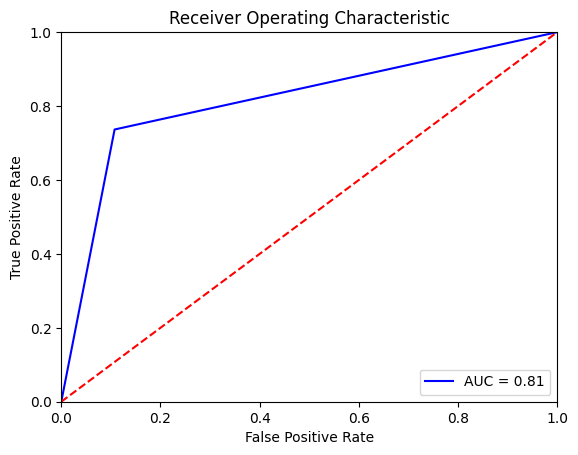

In [134]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [135]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test_scaled)

c:\Users\chewy\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:29:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [136]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Output the results
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Accuracy: 0.8396090370132991
ROC AUC: 0.8174704676819329
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4195
           1       0.76      0.75      0.75      2046

    accuracy                           0.84      6241
   macro avg       0.82      0.82      0.82      6241
weighted avg       0.84      0.84      0.84      6241



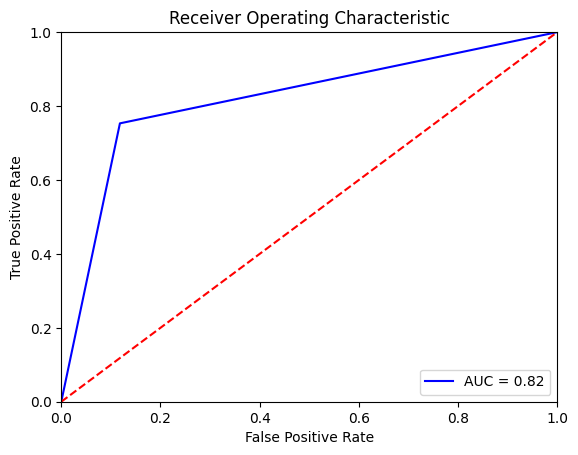

In [137]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()